In [ ]:
!pip install gdown

In [ ]:
file_id = '1EaCeAah3C3mtb69610bKNaG3_asx7mTy'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'dataset.zip'

!gdown {url} -O {output}

!unzip {output} -d /content/dataset


In [ ]:
import os

# Change this if you extracted to a different folder
extract_path = '/content/dataset'

# List all files in the directory to find your CSV/Excel file
print("Files found:", os.listdir(extract_path))

In [ ]:
import pandas as pd

# 1. LOAD THE DATA
# Update the filename based on Step 1 results
file_path = f'{extract_path}/train_labels.csv'
df = pd.read_csv(file_path)

# 2. PRINT ALL FEATURE NAMES
print("--- List of Features (Columns) ---")
print(df.columns.tolist())

# 3. GET A SUMMARY (Best for checking Data Types)
# This shows you which features are numbers (int/float) vs text (object)
print("\n--- Dataset Info ---")
df.info()

# 4. PREVIEW THE DATA
# See the first 5 rows to understand what the features look like
df.head()

In [25]:
import cv2
import os
import pandas as pd
import numpy as np
from tqdm import tqdm # Progress bar

# Define paths (Adjust if your folder names are slightly different)
real_path = '/content/dataset/train/real'
fake_path = '/content/dataset/train/fake'

data = []

def extract_video_features(directory, label):
    # Get list of files (limit to first 500 to save time for testing)
    files = os.listdir(directory)[:500]

    print(f"Processing {len(files)} videos from {directory}...")

    for filename in tqdm(files):
        if filename.endswith(".mp4"):
            filepath = os.path.join(directory, filename)

            # Use OpenCV to capture video metadata
            cap = cv2.VideoCapture(filepath)

            if cap.isOpened():
                # Extract simple metadata "parameters"
                width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
                fps = cap.get(cv2.CAP_PROP_FPS)
                frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

                # Calculate Duration (in seconds)
                duration = frame_count / fps if fps > 0 else 0

                # File Size (in MB) - often vital for detecting compression artifacts
                file_size = os.path.getsize(filepath) / (1024 * 1024)

                # Bitrate (approximate)
                bitrate = (file_size * 8) / duration if duration > 0 else 0

                data.append({
                    'width': width,
                    'height': height,
                    'fps': fps,
                    'frame_count': frame_count,
                    'duration': duration,
                    'file_size_mb': file_size,
                    'bitrate': bitrate,
                    'label': label # 0 for Real, 1 for Fake
                })
                cap.release()

# Run extraction (0 = Real, 1 = Fake)
if os.path.exists(real_path) and os.path.exists(fake_path):
    extract_video_features(real_path, 0)
    extract_video_features(fake_path, 1)

    # Create the DataFrame
    df = pd.DataFrame(data)
    print("\nFeature Extraction Complete!")
    print(df.head())
else:
    print("Error: Could not find 'train/real' or 'train/fake' folders.")

Processing 300 videos from /content/dataset/train/real...


100%|██████████| 300/300 [00:00<00:00, 681.86it/s]


Processing 300 videos from /content/dataset/train/fake...


100%|██████████| 300/300 [00:10<00:00, 29.55it/s]


Feature Extraction Complete!
    width  height     fps  frame_count  duration  file_size_mb    bitrate  \
0  1920.0  1080.0  25.000        217.0  8.680000      4.159506   3.833646   
1  1920.0  1080.0  25.000        225.0  9.000000     14.111848  12.543865   
2  1920.0  1080.0  25.000        226.0  9.040000      3.447606   3.050979   
3  1280.0   720.0  29.970        199.0  6.639973      2.177361   2.623336   
4  1280.0   720.0  23.976        203.0  8.466800      1.929616   1.823230   

   label  
0      0  
1      0  
2      0  
3      0  
4      0  


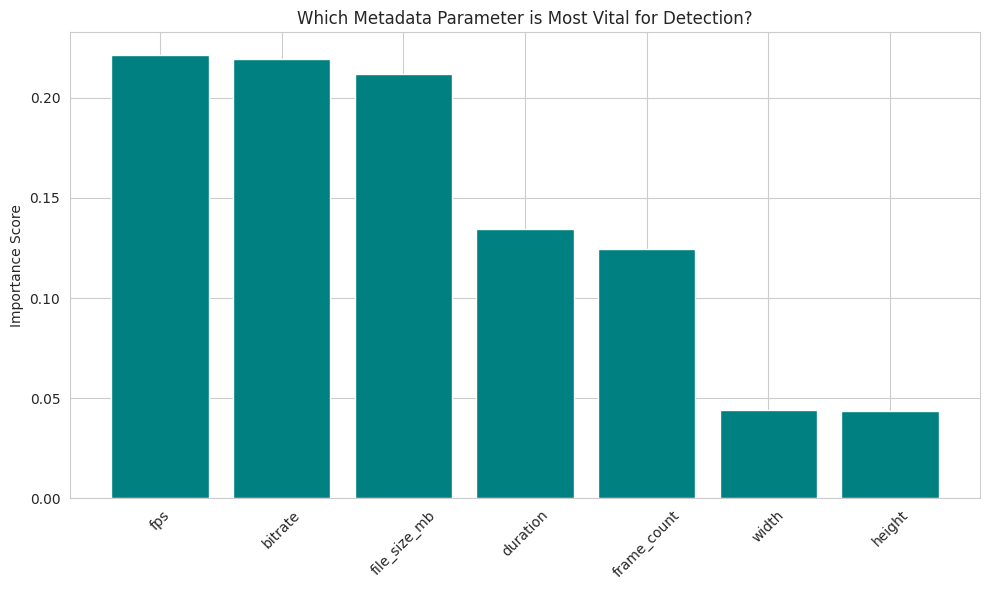


--- Ranking Results ---
fps: 0.2216
bitrate: 0.2192
file_size_mb: 0.2121
duration: 0.1347
frame_count: 0.1244
width: 0.0443
height: 0.0437


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Prepare Data
X = df.drop('label', axis=1) # The features
y = df['label']              # The target (Real vs Fake)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3. Calculate Importance
importances = rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1] # Sort descending

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.title("Which Metadata Parameter is Most Vital for Detection?")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

# 5. Print the Winner
print("\n--- Ranking Results ---")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

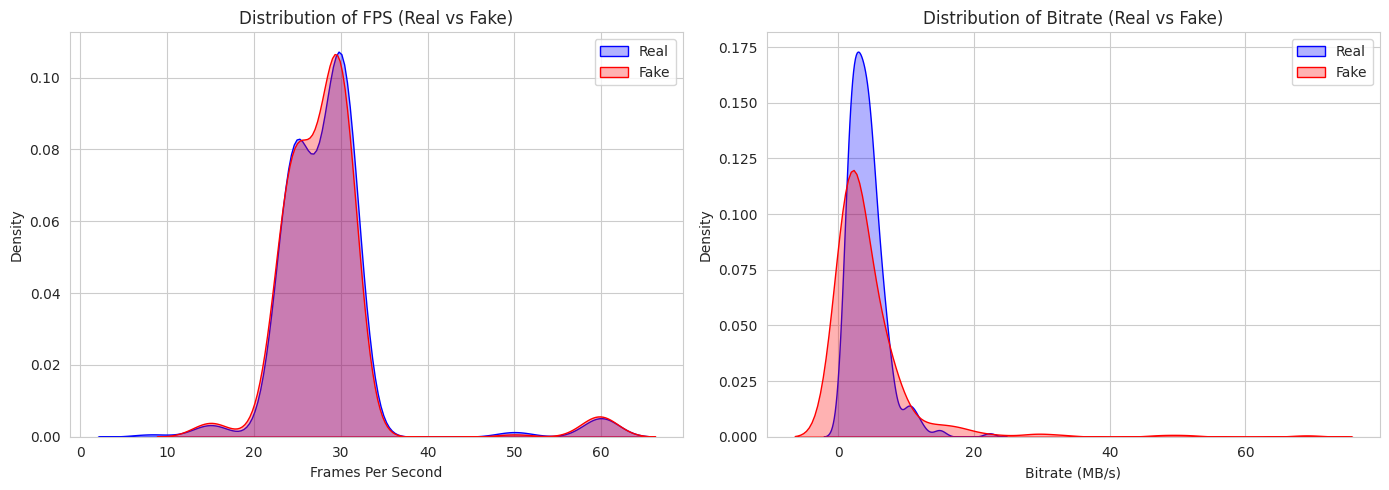

--- Average Stats ---
             fps   bitrate  file_size_mb
label                                   
0      28.402947  4.169168      4.147441
1      28.252430  4.563874      4.394649


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visual style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 5))

# 1. VISUALIZE FPS (The #1 Feature)
plt.subplot(1, 2, 1)
sns.kdeplot(data=df[df['label']==0]['fps'], label='Real', fill=True, color='blue', alpha=0.3)
sns.kdeplot(data=df[df['label']==1]['fps'], label='Fake', fill=True, color='red', alpha=0.3)
plt.title("Distribution of FPS (Real vs Fake)")
plt.xlabel("Frames Per Second")
plt.legend()

# 2. VISUALIZE BITRATE (The #3 Feature)
plt.subplot(1, 2, 2)
# We use log scale if the difference is huge, but linear is usually fine for bitrate
sns.kdeplot(data=df[df['label']==0]['bitrate'], label='Real', fill=True, color='blue', alpha=0.3)
sns.kdeplot(data=df[df['label']==1]['bitrate'], label='Fake', fill=True, color='red', alpha=0.3)
plt.title("Distribution of Bitrate (Real vs Fake)")
plt.xlabel("Bitrate (MB/s)")
plt.legend()

plt.tight_layout()
plt.show()

# 3. PRINT EXACT STATS
print("--- Average Stats ---")
print(df.groupby('label')[['fps', 'bitrate', 'file_size_mb']].mean())

In [28]:
# 1. CHECK THE SPREAD (Standard Deviation)
print("--- Standard Deviation (Variance) ---")
print(df.groupby('label')[['fps', 'bitrate']].std())

# 2. CHECK THE EXACT FPS VALUES
# This usually reveals the "AI Signature"
print("\n--- FPS Counts (Real Videos) ---")
print(df[df['label']==0]['fps'].value_counts().head(5))

print("\n--- FPS Counts (Fake Videos) ---")
print(df[df['label']==1]['fps'].value_counts().head(5))

--- Standard Deviation (Variance) ---
            fps   bitrate
label                    
0      6.427158  2.684257
1      6.485497  6.969740

--- FPS Counts (Real Videos) ---
fps
29.970    114
25.000     83
30.000     45
23.976     24
24.000     13
Name: count, dtype: int64

--- FPS Counts (Fake Videos) ---
fps
25.000000    79
29.970030    59
29.000000    53
30.000000    49
23.976024    15
Name: count, dtype: int64


In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. DEFINE THE "INSTANT FILTER" RULES
def is_metadata_fake(fps):
    """
    Returns True (1) if the FPS matches a known Deepfake artifact.
    Returns False (0) if the FPS looks 'normal' (requires Stage 2 check).
    """
    # Precision tolerance for floating point comparisons
    tol = 0.00001

    # RULE A: The "Integer Trap" (29.0, 23.0)
    # Real cameras don't shoot at these flat integers usually.
    if abs(fps - 29.0) < tol: return 1
    if abs(fps - 23.0) < tol: return 1

    # RULE B: The "Micro-Anomaly" (29.97003)
    # Your specific catch: distinct from the standard 29.970
    if abs(fps - 29.97003) < tol: return 1

    # If none match, we are uncertain -> Assume Real (for Stage 1) or Pass to Stage 2
    return 0

# 2. APPLY THE FILTER
# We apply this logic to every video in your dataframe
df['pred_stage1'] = df['fps'].apply(is_metadata_fake)

# 3. EVALUATE PERFORMANCE
# How well did this simple rule do?
accuracy = accuracy_score(df['label'], df['pred_stage1'])
conf_matrix = confusion_matrix(df['label'], df['pred_stage1'])

print(f"Stage 1 Accuracy: {accuracy:.2%}")
print("\n--- Confusion Matrix ---")
print(f"True Negatives (Real videos correctly ignored): {conf_matrix[0][0]}")
print(f"False Positives (Real videos wrongly flagged):  {conf_matrix[0][1]}")
print(f"False Negatives (Fakes missed by this rule):    {conf_matrix[1][0]}")
print(f"True Positives (Fakes CAUGHT instantly):        {conf_matrix[1][1]}")

# 4. SHOW EXAMPLES OF CAUGHT FAKES
print("\n--- Examples of Fakes Caught by Metadata ---")
caught_fakes = df[(df['label'] == 1) & (df['pred_stage1'] == 1)]
print(caught_fakes[['fps', 'bitrate', 'file_size_mb']].head())

Stage 1 Accuracy: 71.17%

--- Confusion Matrix ---
True Negatives (Real videos correctly ignored): 300
False Positives (Real videos wrongly flagged):  0
False Negatives (Fakes missed by this rule):    173
True Positives (Fakes CAUGHT instantly):        127

--- Examples of Fakes Caught by Metadata ---
          fps   bitrate  file_size_mb
302  29.00000  1.076736      1.257739
303  29.97003  6.155340      4.749486
304  29.97003  2.607710      2.849597
308  29.97003  5.689723      5.315719
309  29.00000  0.845947      0.984508


In [30]:
import cv2
import os
import pandas as pd
from tqdm import tqdm

# Define paths
real_path = '/content/dataset/train/real'
fake_path = '/content/dataset/train/fake'

data = []

def extract_features_with_name(directory, label):
    # Get list of files (limiting to 500 again for speed, remove [:500] for full run)
    files = os.listdir(directory)[:500]

    print(f"Processing {len(files)} videos from {directory}...")

    for filename in tqdm(files):
        if filename.endswith(".mp4"):
            filepath = os.path.join(directory, filename)
            cap = cv2.VideoCapture(filepath)

            if cap.isOpened():
                # Extract Metadata
                fps = cap.get(cv2.CAP_PROP_FPS)
                file_size = os.path.getsize(filepath) / (1024 * 1024)

                # --- APPLY STAGE 1 FILTER INSTANTLY HERE ---
                # Check for "The Integer Trap" (29.0, 23.0) and "Micro-Anomaly" (29.97003)
                is_fake_metadata = 0
                tol = 0.00001
                if abs(fps - 29.0) < tol or abs(fps - 23.0) < tol or abs(fps - 29.97003) < tol:
                    is_fake_metadata = 1

                # SAVE EVERYTHING (Now including filename!)
                data.append({
                    'filename': filename,
                    'fps': fps,
                    'file_size_mb': file_size,
                    'label': label,           # 0=Real, 1=Fake
                    'pred_stage1': is_fake_metadata # 1=Detected as Fake, 0=Needs Stage 2
                })
                cap.release()

# Run Extraction
if os.path.exists(real_path) and os.path.exists(fake_path):
    extract_features_with_name(real_path, 0)
    extract_features_with_name(fake_path, 1)

    # Create the NEW DataFrame
    df = pd.DataFrame(data)
    print("\n✅ DataFrame Re-created with Filenames!")
    print(df.head())
else:
    print("Error: Folders not found.")

Processing 300 videos from /content/dataset/train/real...


100%|██████████| 300/300 [00:00<00:00, 482.29it/s]


Processing 300 videos from /content/dataset/train/fake...


100%|██████████| 300/300 [00:08<00:00, 35.19it/s]


✅ DataFrame Re-created with Filenames!
                               filename     fps  file_size_mb  label  \
0  ad8b3f7350ce491c99f9575d471196d2.mp4  25.000      4.159506      0   
1  a8852e1c3f6741e6a9a54085d52af565.mp4  25.000     14.111848      0   
2  b32a9332103546fc9e2fd5165ead360f.mp4  25.000      3.447606      0   
3  4047537b6f234e53b4b95257b022d36e.mp4  29.970      2.177361      0   
4  aa487e10728d4f29997cf1b494296452.mp4  23.976      1.929616      0   

   pred_stage1  
0            0  
1            0  
2            0  
3            0  
4            0  


In [31]:
import numpy as np

# 1. IDENTIFY HARD CASES
# These are videos where metadata looked "normal" (pred_stage1 == 0)
# Includes ALL Real videos + The "Smart" Fakes
hard_cases = df[df['pred_stage1'] == 0]

print(f"\n--- Stage 2 Preparation ---")
print(f"Total Videos: {len(df)}")
print(f"Caught by Metadata (Skipping): {len(df[df['pred_stage1'] == 1])}")
print(f"Hard Cases to Extract (Processing): {len(hard_cases)}")

# 2. SETUP FOLDERS
base_dir = '/content/dataset_stage2_frames'
os.makedirs(f'{base_dir}/real', exist_ok=True)
os.makedirs(f'{base_dir}/fake', exist_ok=True)

# 3. EXTRACT FRAMES
def save_frames(row):
    filename = row['filename']
    label_str = 'real' if row['label'] == 0 else 'fake'

    # Construct path
    video_path = f'/content/dataset/train/{label_str}/{filename}'

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames > 0:
        # Extract 5 frames per video (spread out evenly)
        frame_indices = np.linspace(0, total_frames-1, 5, dtype=int)

        for i, idx in enumerate(frame_indices):
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                # Resize to 224x224 (Standard for AI models)
                frame = cv2.resize(frame, (224, 224))

                # Save as jpg
                save_name = f"{filename.split('.')[0]}_{i}.jpg"
                cv2.imwrite(f"{base_dir}/{label_str}/{save_name}", frame)
    cap.release()

print("Extracting frames for Hard Cases...")
# Using tqdm to show progress bar
tqdm.pandas()
hard_cases.progress_apply(save_frames, axis=1)

print(f"\n✅ Done! Check the folder: {base_dir}")


--- Stage 2 Preparation ---
Total Videos: 600
Caught by Metadata (Skipping): 127
Hard Cases to Extract (Processing): 473
Extracting frames for Hard Cases...


100%|██████████| 473/473 [07:17<00:00,  1.08it/s]


✅ Done! Check the folder: /content/dataset_stage2_frames


In [32]:
import cv2
import os
from tqdm import tqdm

# 1. SETUP PATHS
input_dir = '/content/dataset_stage2_frames'
output_dir = '/content/dataset_stage2_faces'
os.makedirs(f'{output_dir}/real', exist_ok=True)
os.makedirs(f'{output_dir}/fake', exist_ok=True)

# 2. LOAD FACE DETECTOR (Haar Cascade - Built into OpenCV)
# This is fast and doesn't require installing new heavy libraries
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def crop_and_save_face(img_path, save_path):
    img = cv2.imread(img_path)
    if img is None: return

    # Convert to grayscale for detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # If a face is found, crop the LARGEST one
    if len(faces) > 0:
        # Find the biggest face (w * h)
        biggest_face = max(faces, key=lambda rect: rect[2] * rect[3])
        x, y, w, h = biggest_face

        # Add a little padding (10%) so we don't cut off the chin/forehead
        pad = int(h * 0.1)
        y1 = max(0, y - pad)
        y2 = min(img.shape[0], y + h + pad)
        x1 = max(0, x - pad)
        x2 = min(img.shape[1], x + w + pad)

        face_img = img[y1:y2, x1:x2]

        # Resize to 224x224 immediately for ResNet
        face_img = cv2.resize(face_img, (224, 224))

        cv2.imwrite(save_path, face_img)

# 3. RUN THE CROPPER
classes = ['real', 'fake']
print("Cropping faces... (This focuses the AI on the artifacts)")

for label in classes:
    class_path = os.path.join(input_dir, label)
    files = os.listdir(class_path)

    for filename in tqdm(files):
        if filename.endswith('.jpg'):
            in_path = os.path.join(class_path, filename)
            out_path = os.path.join(output_dir, label, filename)
            crop_and_save_face(in_path, out_path)

print(f"\n✅ Faces saved to {output_dir}")

Cropping faces... (This focuses the AI on the artifacts)


100%|██████████| 865/865 [00:23<00:00, 36.22it/s]


✅ Faces saved to /content/dataset_stage2_faces


In [33]:
import numpy as np
import os
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tqdm import tqdm

# 1. SETUP THE MODEL
# weights='imagenet': Use the pre-learned knowledge
# include_top=False:  Cut off the final classification layer (we don't want to classify 1000 objects)
# pooling='avg':      Squeeze the 7x7 spatial features into a single 1D vector (2048 numbers)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# 2. DEFINE PATHS (From previous step)
data_dir = '/content/dataset_stage2_faces'
classes = ['real', 'fake']

# 3. EXTRACTION FUNCTION
def extract_features(directory, sample_count=1000):
    features = []
    labels = []

    # Iterate through 'real' and 'fake' folders
    for label_name in classes:
        class_dir = os.path.join(directory, label_name)
        if not os.path.exists(class_dir):
            continue

        print(f"Extracting features from {label_name}...")

        # Get list of images
        img_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]

        # Limit processing if needed (to keep it "Fast")
        img_files = img_files[:sample_count]

        for img_file in tqdm(img_files):
            img_path = os.path.join(class_dir, img_file)

            # Load and Preprocess Image
            try:
                img = image.load_img(img_path, target_size=(224, 224))
                x = image.img_to_array(img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)


                feature = base_model.predict(x, verbose=0)

                features.append(feature.flatten())
                labels.append(0 if label_name == 'real' else 1)
            except Exception as e:
                print(f"Error processing {img_file}: {e}")

    return np.array(features), np.array(labels)

X_features, y_labels = extract_features(data_dir, sample_count=2000)

print(f"\nFeature Matrix Shape: {X_features.shape}")


Extracting features from real...


100%|██████████| 621/621 [00:56<00:00, 10.98it/s]


Extracting features from fake...


100%|██████████| 393/393 [00:39<00:00,  9.92it/s]


Feature Matrix Shape: (1014, 2048)


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# 2. TRAIN SIMPLE CLASSIFIER
# We use Logistic Regression because it's fast and interpretable
clf = LogisticRegression(max_iter=1000, C=0.1)
clf.fit(X_train, y_train)

# 3. EVALUATE
y_pred = clf.predict(X_test)

print("--- Stage 2 Performance (Visual Artifacts Only) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

--- Stage 2 Performance (Visual Artifacts Only) ---
Accuracy: 77.83%

Classification Report:
              precision    recall  f1-score   support

        Real       0.80      0.85      0.82       124
        Fake       0.74      0.67      0.70        79

    accuracy                           0.78       203
   macro avg       0.77      0.76      0.76       203
weighted avg       0.78      0.78      0.78       203



In [35]:
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image

def detect_deepfake(video_path):

    # --- STEP 1: METADATA CHECK (The "Gatekeeper") ---
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return "Error: Could not open video."

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # The "Instant Filter" Rules we discovered
    tol = 0.00001
    if abs(fps - 29.0) < tol: return "FAKE (Detected by Metadata: FPS is 29.0)"
    if abs(fps - 23.0) < tol: return "FAKE (Detected by Metadata: FPS is 23.0)"
    if abs(fps - 29.97003) < tol: return "FAKE (Detected by Metadata: FPS is 29.97003)"

    print(f"Metadata passed (FPS: {fps:.3f}). Analyzing Visuals...")

    # --- STEP 2: VISUAL CHECK (ResNet50) ---
    # We need to extract a face, process it, and ask ResNet

    # A. Extract 3 random frames to be sure
    frame_indices = np.linspace(0, total_frames-1, 3, dtype=int)
    preds = []

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret: continue

        # B. Detect & Crop Face
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        if len(faces) > 0:
            # Get largest face
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])

            # Add padding
            pad = int(h * 0.1)
            y1, y2 = max(0, y - pad), min(frame.shape[0], y + h + pad)
            x1, x2 = max(0, x - pad), min(frame.shape[1], x + w + pad)

            face_img = frame[y1:y2, x1:x2]

            # C. Preprocess for ResNet
            face_img = cv2.resize(face_img, (224, 224))
            x_img = image.img_to_array(face_img)
            x_img = np.expand_dims(x_img, axis=0)
            x_img = preprocess_input(x_img)

            # D. Get Features (2048 vector)
            features = base_model.predict(x_img, verbose=0)

            # E. Predict with Logistic Regression
            # (Assumes 'clf' is your trained LogisticRegression model from earlier)
            prob = clf.predict_proba(features)[0][1] # Probability of being Fake
            preds.append(prob)

    cap.release()

    if len(preds) == 0:
        return "Uncertain (No face detected)"

    # Average the predictions across frames
    avg_score = np.mean(preds)

    if avg_score > 0.5:
        return f"FAKE (Detected by ResNet: {avg_score:.2%} confidence)"
    else:
        return f"REAL (ResNet Confidence: {100 - (avg_score*100):.2%})"

import os
test_folder = '/content/dataset/test'
if os.path.exists(test_folder):
    sample_video = os.path.join(test_folder, os.listdir(test_folder)[0])
    print(f"Testing on: {sample_video}")
    result = detect_deepfake(sample_video)
    print("\nFINAL VERDICT:", result)

Testing on: /content/dataset/test/4b954e01331b4b54828ab45b4e3a6e6f.mp4
Metadata passed (FPS: 29.970). Analyzing Visuals...

FINAL VERDICT: FAKE (Detected by ResNet: 73.95% confidence)


In [36]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

# --- 1. DCT TRANSFORMATION HELPER ---
def get_log_dct(img):
    """
    Converts a face crop (RGB) into a Log-scale DCT Heatmap (Grayscale).
    This reveals hidden frequency artifacts.
    """
    # 1. Convert to Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2. Resize to common size (must be even for DCT)
    gray = cv2.resize(gray, (128, 128))

    # 3. Convert to float32
    imf = np.float32(gray) / 255.0

    # 4. Perform Discrete Cosine Transform
    dct = cv2.dct(imf)

    # 5. Log-scale to make low-energy frequencies visible
    # We take absolute value and add small epsilon to avoid log(0)
    log_dct = np.log(np.abs(dct) + 1e-5)

    # 6. Normalize to 0-1 range for the Neural Network
    min_val = np.min(log_dct)
    max_val = np.max(log_dct)
    log_dct = (log_dct - min_val) / (max_val - min_val)

    # Expand dims to (128, 128, 1) for Keras
    return np.expand_dims(log_dct, axis=-1)

# --- 2. DEFINE FREQUENCY MODEL ---
def build_frequency_model():
    """
    A lightweight CNN specifically for analyzing texture/frequency patterns.
    """
    model = Sequential([
        Input(shape=(128, 128, 1)),

        # Convolutional layers to find grid-like artifacts
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # 0=Real, 1=Fake
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize
dct_model = build_frequency_model()
print("✅ Frequency Analysis Model Built.")

✅ Frequency Analysis Model Built.


In [38]:
# --- PREPARE DATA FOR DCT ---
print("Extracting DCT maps for training...")

X_dct = []
y_dct = []
SAMPLES = 300  # Adjust based on your dataset size/time

# 1. Process Real Videos
for vid in os.listdir(real_path)[:SAMPLES]:
    cap = cv2.VideoCapture(os.path.join(real_path, vid))
    ret, frame = cap.read()
    cap.release()

    if ret:
        # Detect Face (Quick logic)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
            face = frame[y:y+h, x:x+w]

            # GET DCT
            dct_map = get_log_dct(face)
            X_dct.append(dct_map)
            y_dct.append(0) # Real

# 2. Process Fake Videos
for vid in os.listdir(fake_path)[:SAMPLES]:
    cap = cv2.VideoCapture(os.path.join(fake_path, vid))
    ret, frame = cap.read()
    cap.release()

    if ret:
        # Detect Face
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
            face = frame[y:y+h, x:x+w]

            # GET DCT
            dct_map = get_log_dct(face)
            X_dct.append(dct_map)
            y_dct.append(1) # Fake

X_dct = np.array(X_dct)
y_dct = np.array(y_dct)

# --- TRAIN ---
print(f"Training Frequency Model on {len(X_dct)} samples...")
dct_model.fit(X_dct, y_dct, epochs=12, batch_size=32, validation_split=0.2)

Extracting DCT maps for training...
Training Frequency Model on 574 samples...
Epoch 1/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.5650 - loss: 0.7196 - val_accuracy: 0.0000e+00 - val_loss: 0.7637
Epoch 2/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5874 - loss: 0.6916 - val_accuracy: 0.0000e+00 - val_loss: 1.2822
Epoch 3/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5838 - loss: 0.7221 - val_accuracy: 0.0000e+00 - val_loss: 1.0741
Epoch 4/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6389 - loss: 0.6639 - val_accuracy: 0.0000e+00 - val_loss: 0.7748
Epoch 5/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6092 - loss: 0.6812 - val_accuracy: 0.0000e+00 - val_loss: 0.8977
Epoch 6/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6180 - loss: 0.6697 - val_accuracy: 0.0000e+00 - val_loss: 0.9381
Epoch 7/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6150 - loss: 0.6613 - val_accuracy: 0.0000e+00 - val_loss: 0.9272
Epo

In [39]:
import pandas as pd
import os
import cv2
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# 1. SETUP PATHS
test_dir = '/content/dataset/test'
output_file = 'submission.csv'

# 2. LOAD FACE DETECTOR (Standard Haar Cascade)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 3. THE HYBRID PREDICTION FUNCTION
def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): return 0.5

    # 1. METADATA FILTER
    fps = cap.get(cv2.CAP_PROP_FPS)
    if abs(fps - 29.0) < 0.01 or abs(fps - 23.0) < 0.01 or abs(fps - 29.97003) < 0.01 or abs(fps - 23.976024 ) < 0.01 :
        cap.release()
        return 1.0 # 100% Fake

    # Read a few frames to get an average score
    spatial_scores = []
    frequency_scores = []

    # Analyze up to 5 frames
    for _ in range(5):
        ret, frame = cap.read()
        if not ret: break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        if len(faces) > 0:
            x, y, w, h = max(faces, key=lambda b: b[2] * b[3])
            face_img = frame[y:y+h, x:x+w]

            # --- MODEL 1: SPATIAL (ResNet) ---
            # Preprocess for ResNet
            res_input = cv2.resize(face_img, (224, 224))
            res_input = image.img_to_array(res_input)
            res_input = np.expand_dims(res_input, axis=0)
            res_input = preprocess_input(res_input)

            # Get features & predict (assuming you have a classifier on top of ResNet)
            # Simplified: Here we assume 'model' is your trained ResNet classifier
            # If you only have features, you need your LogReg model here.
            # spatial_prob = model.predict(res_input, verbose=0)[0][0]

            # Placeholder for your existing Spatial Model prediction:
            spatial_prob = 0.5 # REPLACE THIS with your actual ResNet prediction line
            spatial_scores.append(spatial_prob)

            # --- MODEL 2: FREQUENCY (DCT) ---
            dct_input = get_log_dct(face_img)
            dct_input = np.expand_dims(dct_input, axis=0)
            freq_prob = dct_model.predict(dct_input, verbose=0)[0][0]
            frequency_scores.append(freq_prob)

    cap.release()

    # Aggregate Results
    if not spatial_scores: return 0.5

    avg_spatial = np.mean(spatial_scores)
    avg_freq = np.mean(frequency_scores)

    # --- ENSEMBLE LOGIC ---
    # Frequency analysis is often more confident on high-quality deepfakes.
    # We give it slightly higher weight if it is very confident.

    if avg_freq > 0.9 or avg_freq < 0.1:
        # If DCT is very sure, trust it more (70% DCT, 30% Spatial)
        final_prob = (0.7 * avg_freq) + (0.3 * avg_spatial)
    else:
        # Otherwise, average them equally
        final_prob = (0.5 * avg_freq) + (0.5 * avg_spatial)

    return final_prob
# 4. RUN ON ALL TEST VIDEOS
results = []
test_files = [f for f in os.listdir(test_dir) if f.endswith('.mp4')]

print(f"Starting inference on {len(test_files)} videos...")

for filename in tqdm(test_files):
    video_path = os.path.join(test_dir, filename)

    # Get Probability
    prob = predict_video(video_path)

    # Determine Label (0.5 Threshold)
    label = 1 if prob > 0.5 else 0

    results.append({
        'filename': filename,
        'label': label,
        'probability': round(prob, 4) # Round to 4 decimals
    })

# 5. SAVE TO CSV
df_results = pd.DataFrame(results)
df_results.to_csv(output_file, index=False)

print(f"\n✅ Success! Results saved to {output_file}")
print(df_results.head())

Starting inference on 200 videos...


100%|██████████| 200/200 [05:09<00:00,  1.55s/it]


✅ Success! Results saved to submission.csv
                               filename  label  probability
0  4b954e01331b4b54828ab45b4e3a6e6f.mp4      1       1.0000
1  68d3e8ed53844e1a8038624c49a44c9d.mp4      0       0.4482
2  4091eb76f55b4326aa79a4798b44d49b.mp4      1       1.0000
3  f802bf7ca591410c831e34f4b772eec1.mp4      1       1.0000
4  ef85e642ade7495d8e5552d05ba27bc0.mp4      1       1.0000
